In [1]:
import time
import os
import gc

import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
np.set_printoptions(precision=6, suppress=True)

import PIL
from PIL import Image

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
tf.__version__

'2.3.0'

In [2]:
from imageio import imread
import matplotlib.pyplot as plt

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Hyperparameters

In [6]:
PRE_TRAINED = './models/pg_convnet.h5'
TRAINING_EPOCHS = 200
LEARNING_RATE = 0.001
EPSILON = 1e-08
BATCH_SIZE = 128

# Data preparation

In [7]:
l = np.load('./results/pg_dataset.npz', allow_pickle=True)
data_indices_2020S = l['data_indices_2020S']
output_label_2020S = l['output_label_2020S']
data_indices_2020W = l['data_indices_2020W']
output_label_2020W = l['output_label_2020W']
OUTPUT_MAXS = l['OUTPUT_MAXS']
OUTPUT_MINS = l['OUTPUT_MINS']

In [8]:
COLUMNS = ['node_len', 'node_dia', 'plant_h', 'leaf_area']

In [9]:
output_2020S_df = pd.DataFrame(output_label_2020S, index=data_indices_2020S, columns=COLUMNS)
output_2020W_df = pd.DataFrame(output_label_2020W, index=data_indices_2020W, columns=COLUMNS)

In [10]:
DIRECTORY = './images/2020_W/'
dir_list = os.listdir(DIRECTORY)
dataset_list = [direc for direc in dir_list if direc.startswith('LAI_OVER') or direc.startswith('LAI2_OVER')]
dataset_list.sort()

In [11]:
data_indices = []
input_images = []
output_labels = []
for DATE in output_2020W_df.index:
    for DIRECTORY in dataset_list:
        if DATE in DIRECTORY:
            file_list = os.listdir(f'./images/2020_W/{DIRECTORY}')
            file_list = [file for file in file_list if file.endswith('.jpg')]
            for FILE in file_list:
                TIME = pd.Timedelta(FILE.split()[-1].split('.')[0])
                if TIME >= pd.Timedelta('08:00:00') and TIME <= pd.Timedelta('16:00:00'):
                    image = Image.open(f'./images/2020_W/{DIRECTORY}/{FILE}')
                    data_indices.append(pd.Timestamp(DATE))
                    input_images.append(img_to_array(image))
                    output_labels.append(output_2020W_df.loc[DATE].values)

In [12]:
input_images = np.stack(input_images, axis=0)
output_labels = np.stack(output_labels, axis=0)
data_indices = np.array(data_indices)

In [13]:
print(len(data_indices))
print(input_images.shape)
print(output_labels.shape)

6505
(6505, 256, 256, 3)
(6505, 4)


In [14]:
data_indices, input_images, output_labels = resample(data_indices, input_images, output_labels, n_samples=3000, replace=False, random_state=4574)

In [15]:
print(len(data_indices))
print(input_images.shape)
print(output_labels.shape)

3000
(3000, 256, 256, 3)
(3000, 4)


In [16]:
gc.collect()

11

In [17]:
N_TRAIN = int(output_labels.shape[0]*.1)
train_input = input_images[:N_TRAIN, ...]
train_label = output_labels[:N_TRAIN, ...]
train_index = data_indices[:N_TRAIN]
test_input = input_images[N_TRAIN:, ...]
test_label = output_labels[N_TRAIN:, ...]
test_index = data_indices[N_TRAIN:]

In [18]:
train_index, val_index, train_input, val_input, train_label, val_label = train_test_split(train_index, train_input, train_label, test_size=0.3, shuffle=True, random_state=3101)

In [19]:
datagen = ImageDataGenerator(
    rescale=1/255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

In [20]:
train_iterator = datagen.flow(train_input, train_label, batch_size=BATCH_SIZE)
val_iterator = datagen.flow(val_input, val_label, batch_size=BATCH_SIZE)
test_iterator = datagen.flow(test_input, test_label, batch_size=BATCH_SIZE)

In [21]:
print(f'number of data set: {input_images.shape[0]}')
print(f'number of training set: {train_input.shape[0]}')
print(f'number of validation set: {val_input.shape[0]}')
print(f'number of test set: {test_input.shape[0]}')

number of data set: 3000
number of training set: 210
number of validation set: 90
number of test set: 2700


In [22]:
gc.collect()

0

# Model construction

In [23]:
class ResidualBlock(layers.Layer):
    def __init__(self, num_filter, stride=1):
        super(ResidualBlock, self).__init__()
        self.n = num_filter
        self.s = stride
        
        self.conv1 = layers.Conv2D(filters=self.n, kernel_size=1, strides=1, kernel_initializer='glorot_normal', padding='same')
        self.norm1 = layers.BatchNormalization()
        self.act1 = layers.Activation(activations.relu)
        self.conv2 = layers.Conv2D(filters=self.n, kernel_size=3, strides=stride, kernel_initializer='glorot_normal', padding='same')
        self.norm2 = layers.BatchNormalization()
        self.act2 = layers.Activation(activations.relu)
        self.conv3 = layers.Conv2D(filters=self.n*4, kernel_size=1, strides=1, kernel_initializer='glorot_normal', padding='same')
        self.norm3 = layers.BatchNormalization()
        self.act3 = layers.Activation(activations.relu)

        self.downsample = Sequential()
        self.downsample.add(layers.Conv2D(filters=self.n*4, kernel_size=1, strides=stride, kernel_initializer='glorot_normal'))
        self.downsample.add(layers.BatchNormalization())

    def call(self, inp, training=None, **kwargs):
        shortcut = self.downsample(inp)

        inp = self.act1(self.norm1(self.conv1(inp), training=training))
        inp = self.act2(self.norm2(self.conv2(inp), training=training))
        inp = self.norm3(self.conv3(inp), training=training)

        oup = self.act3(layers.add([shortcut, inp]))

        return oup

In [24]:
def block_maker(num_filter, num_blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(ResidualBlock(num_filter, stride=stride))

    for _ in range(1, num_blocks):
        res_block.add(ResidualBlock(num_filter, stride=1))

    return res_block

In [25]:
class ResNet2D(Model):
    def __init__(self, layer_params):
        super(ResNet2D, self).__init__()
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, kernel_initializer='glorot_normal', padding="same")
        self.norm1 = layers.BatchNormalization()
        self.act1 = layers.Activation(activations.relu)
        self.pool1 = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same")

        self.layer1 = block_maker(num_filter=64, num_blocks=layer_params[0])
        self.layer2 = block_maker(num_filter=128, num_blocks=layer_params[1], stride=2)
        self.layer3 = block_maker(num_filter=256, num_blocks=layer_params[2], stride=2)
        self.layer4 = block_maker(num_filter=512, num_blocks=layer_params[3], stride=2)

        self.flat = layers.Flatten()
        self.dense1 = layers.Dense(units=512, activation='relu')
        self.dense2 = layers.Dense(units=128, activation='relu')
        self.fc = layers.Dense(units=4)

    def call(self, inp, training=None, mask=None):
        inp = self.conv1(inp)
        inp = self.norm1(inp, training=training)
        inp = self.act1(inp)
        inp = self.pool1(inp)
        inp = self.layer1(inp, training=training)
        inp = self.layer2(inp, training=training)
        inp = self.layer3(inp, training=training)
        inp = self.layer4(inp, training=training)
        inp = self.dense1(self.flat(inp))
        inp = self.dense2(inp)
        output = self.fc(inp)

        return output

In [26]:
with strategy.scope():
    model = ResNet2D(layer_params=[2, 3, 2, 1])

In [27]:
with strategy.scope():
    opt = optimizers.Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    model.compile(optimizer=opt, loss='mae')
    model.predict(test_input[:5, ...]/255)
    model.load_weights(PRE_TRAINED)

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then br

In [28]:
del(train_index)
del(train_input)
del(train_iterator)
del(train_label)
del(val_index)
del(val_input)
del(val_iterator)
del(val_label)

In [29]:
gc.collect()

1390

In [30]:
pred_result = model.predict(test_input/255)

In [31]:
print(pred_result.shape)
print(test_label.shape)

(2700, 4)
(2700, 4)


In [32]:
test_label = (OUTPUT_MAXS - OUTPUT_MINS)*test_label + OUTPUT_MINS
pred_result = (OUTPUT_MAXS - OUTPUT_MINS)*pred_result + OUTPUT_MINS

In [33]:
pred_df = pd.DataFrame(np.concatenate([test_label, pred_result], axis=1), index=test_index)
pred_df.columns = ['label_node_len', 'label_node_dia', 'label_plant_h', 'label_leaf_area', 'pred_node_len', 'pred_node_dia', 'pred_plant_h', 'pred_leaf_area']

### Check outlier

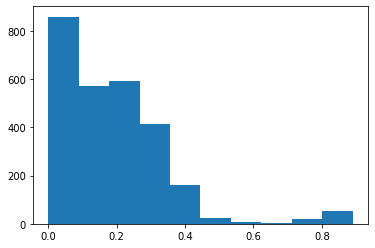

In [34]:
plt.hist(abs(pred_df['label_leaf_area'] - pred_df['pred_leaf_area']).values)
plt.show()

In [35]:
pred_df.to_csv('./results/model_output/pg_pred_result_pre.csv')

In [36]:
outliers_df = pred_df.reset_index()
outliers_df = outliers_df.loc[abs(outliers_df['label_leaf_area'] - outliers_df['pred_leaf_area']) > 0.5]
outliers_df = outliers_df[['index', 'label_node_len', 'pred_node_len', 'label_node_dia', 'pred_node_dia', 'label_plant_h', 'pred_plant_h', 'label_leaf_area', 'pred_leaf_area']]

In [37]:
wrong_input = test_input[outliers_df.index]

In [38]:
outliers_df.head()

,index,label_node_len,pred_node_len,label_node_dia,pred_node_dia,label_plant_h,pred_plant_h,label_leaf_area,pred_leaf_area
2,2020-11-18,6.813297,5.457348,10.296954,9.609233,173.927744,114.014141,1.249819,0.610099
3,2020-11-16,6.799136,4.658543,10.289725,9.198980,172.273539,87.272379,1.238181,0.393891
38,2020-11-14,6.783182,4.817393,10.281454,9.315084,170.446967,95.129341,1.224628,0.460483
57,2020-11-15,6.791396,4.722595,10.285729,9.248591,171.382628,91.192686,1.231660,0.428053
81,2020-11-17,6.806428,6.429596,10.293461,9.859754,173.121361,129.458210,1.244224,0.711351


In [39]:
test_input.shape

(2700, 256, 256, 3)

In [40]:
outliers_df.shape

(86, 9)

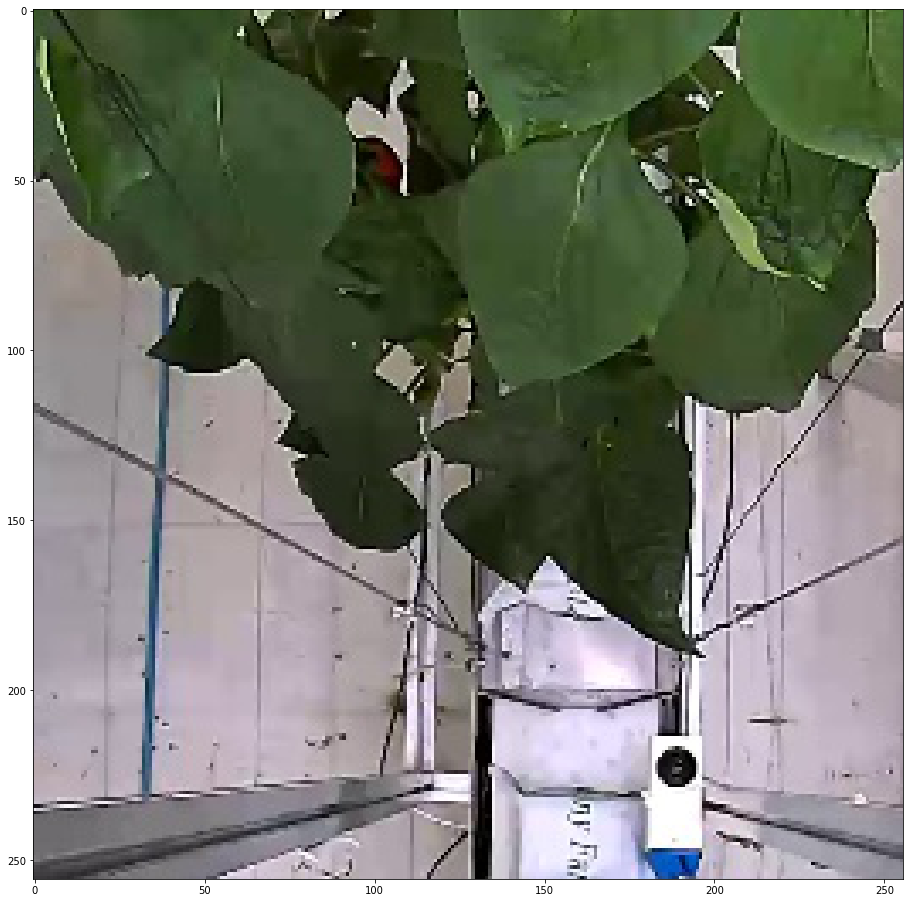

In [41]:
# Plot
plt.figure(0, figsize=(16,16))
plt.imshow(wrong_input[-1].astype('int'))
plt.draw()